In [2]:
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
import en_core_web_md
from sklearn.preprocessing import MinMaxScaler
import transformers
import torch
from scipy import sparse



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\eduar\uni\UTS\NLP\assignment_2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MINIMUM_NUMBER_OF_WORDS = 10
RESUME_SECTIONS = ["Title", "Summary", "Highlights", "Experience", "Education", "Skills", "Portfolio", "Publications", "Accomplishments", "Certifications", "Interests", "Credentials", "Projects", "Professional Profile", "Career Focus"]
RELEVANT_SECTIONS = ['Title','Summary','Experience', 'Education', 'Skills', 'Projects', 'Highlights', 'Accomplishments']
JOB_DESCRIPTION_SECTIONS = ["Core Responsibilities", "Educational Requirements", "Required Skills", "Preferred Qualifications", "Experience Level"]
ADDITIONAL_STOPWORDS = {"state", "company", "city", "name"}
MAX_N_GRAM_MATCHING = 2
TEST_SIZE = .3
RANDOM_STATE = 42

# Import and Preporcess the Data

In [4]:
df_resumes = pd.read_csv("Resume/Resume.csv")
df_job_descriptions = pd.read_csv("JobDescription/training_data.csv")

In [5]:
df_resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [6]:
df_job_descriptions.head()

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."


In [7]:
df_resumes.columns = list(map(str.upper, df_resumes.columns))
df_job_descriptions.columns = list(map(str.upper, df_job_descriptions.columns))

In [8]:
df_resumes.set_index("ID", inplace = True)

In [9]:
label_encoder = LabelEncoder()
df_resumes["CATEGORY_ENCODED"] = label_encoder.fit_transform(df_resumes["CATEGORY"])

In [10]:
possible_sections = []
df_resumes["RESUME_STR"].apply(lambda resume_str: possible_sections.extend(resume_str.split(5 * " ")))
possible_sections = set(filter(lambda section: len(section.split(" ")) == 1 and section != "", possible_sections))

In [11]:
stop_words = set(stopwords.words("english")).union(ADDITIONAL_STOPWORDS)
lemmatizer = WordNetLemmatizer()
RESUME_SECTIONS = [lemmatizer.lemmatize(sect) for sect in RESUME_SECTIONS]

## Structure the raw data

In [12]:
# this was done to find the possible categories that can be used to classify the resumes and therefore bring
# more structure to the data
possible_categories = []
for str_resume in df_resumes['RESUME_STR']:
    temp = str_resume.split("     ")
    temp = [x for x in temp if len(x.split(" ")) == 1 and x != '']
    possible_categories += temp
    possible_categories = list(set(possible_categories))

In [13]:
def preprocess_section(section_str):
    section_str = section_str.lower()
    section_str = " ".join([word for word in section_str.split() if word not in stop_words and (word.isalnum() and not "/" in word)])
    section_str = " ".join([lemmatizer.lemmatize(word) for word in section_str.split()])
    return section_str

def split_into_sections(str_to_split, sections):
    section_indices = {section: str_to_split.find(section) for section in sections}
    section_indices = {section: section_index for section, section_index in sorted(section_indices.items(), key = lambda item: item[1]) if section_index !=-1}
    section_indices["end"] = -1
    return section_indices, list(section_indices.keys())

def preprocess_resume_string(resume_str):
    resume_str = resume_str.replace("\n", " ").replace("\t", " ")
    section_indices, resume_sections = split_into_sections(resume_str, RESUME_SECTIONS)
    resume_json = {section: preprocess_section(resume_str[section_indices[section]+len(section):section_indices[resume_sections[resume_sections.index(section)+1]]]) for section in resume_sections if section_indices[section] != -1}
    resume_json["Title"] = preprocess_section(resume_str[:section_indices[resume_sections[0]]])
    return resume_json

def preprocess_job_description_string(job_description_str):
    job_description_str = job_description_str.replace("\n}", "").replace(" {\n  ", "").replace("\n", "").replace('"', "")
    section_indices, job_description_sections = split_into_sections(job_description_str, JOB_DESCRIPTION_SECTIONS)
    job_description_json = {section: preprocess_section(job_description_str[section_indices[section]+len(section):section_indices[job_description_sections[job_description_sections.index(section)+1]]]) for section in job_description_sections if section_indices[section] != -1}
    return job_description_json

In [14]:
df_resumes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2484 entries, 16852973 to 37473139
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   RESUME_STR        2484 non-null   object
 1   RESUME_HTML       2484 non-null   object
 2   CATEGORY          2484 non-null   object
 3   CATEGORY_ENCODED  2484 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 87.3+ KB


In [15]:
df_resumes["RESUME_JSON"] = df_resumes["RESUME_STR"].apply(preprocess_resume_string)
df_resumes["RESUME_STR_PREPROCESSED"] = df_resumes["RESUME_JSON"].apply(lambda resume_json: " ".join(list(resume_json.values())))

In [16]:
df_job_descriptions["JOB_DESCRIPTION_JSON"] = df_job_descriptions["MODEL_RESPONSE"].apply(preprocess_job_description_string)
df_job_descriptions["JOB_DESCRIPTION_JSON"] = df_job_descriptions.apply(lambda job_description: {**job_description["JOB_DESCRIPTION_JSON"], "Title": job_description["POSITION_TITLE"]}, axis = 1)
df_job_descriptions["JOB_DESCRIPTION_PREPROCESSED"] = df_job_descriptions["JOB_DESCRIPTION_JSON"].apply(lambda job_description_json: " ".join(list(job_description_json.values())))

In [17]:
df_resumes.drop(["RESUME_HTML", "RESUME_STR"], axis = 1, inplace = True)
df_job_descriptions.drop(["POSITION_TITLE", "JOB_DESCRIPTION", "DESCRIPTION_LENGTH", "MODEL_RESPONSE"], axis = 1, inplace = True)

In [18]:
empty_resumes = df_resumes[df_resumes["RESUME_STR_PREPROCESSED"].apply(lambda resume_str: len(resume_str.split(" "))) < MINIMUM_NUMBER_OF_WORDS]
df_resumes.drop(empty_resumes.index, inplace = True)

In [19]:
empty_job_descriptions = df_job_descriptions.JOB_DESCRIPTION_JSON.apply(lambda job_description_json: len(("".join(list(job_description_json.values())).split(" "))))
empty_job_descriptions = empty_job_descriptions[empty_job_descriptions < MINIMUM_NUMBER_OF_WORDS]
df_job_descriptions.drop(empty_job_descriptions.index, inplace = True)

In [20]:
df_resumes.drop_duplicates("RESUME_STR_PREPROCESSED", inplace = True)

In [21]:
df_resumes.head()

,CATEGORY,CATEGORY_ENCODED,RESUME_JSON,RESUME_STR_PREPROCESSED
ID,,,,
16852973,HR,19,{'Summary': 'dedicated customer service manage...,dedicated customer service manager year experi...
22323967,HR,19,{'Summary': 'versatile medium professional bac...,versatile medium professional background human...
33176873,HR,19,{'Summary': '20 year experience 15 plus year h...,20 year experience 15 plus year human resource...
27018550,HR,19,{'Summary': 'dynamic 20 year customer service ...,dynamic 20 year customer service motivated mai...
17812897,HR,19,{'Highlights': 'hr skill hr department startup...,hr skill hr department startup three new organ...


In [22]:
df_job_descriptions.head()

,COMPANY_NAME,JOB_DESCRIPTION_JSON,JOB_DESCRIPTION_PREPROCESSED
0,Google,{'Core Responsibilities': 'responsible expandi...,responsible expanding google workspace product...
1,Apple,{'Core Responsibilities': 'asc highly influent...,asc highly influential growing mind market sha...
2,Netflix,{'Core Responsibilities': 'help drive business...,help drive business supporting licensing manag...
3,Robert Half,{'Core Responsibilities': 'designing landing m...,designing landing mobile implementing design u...
4,TrackFive,{'Core Responsibilities': 'build layout provid...,build layout provided psd build dynamic web ap...


# EDA

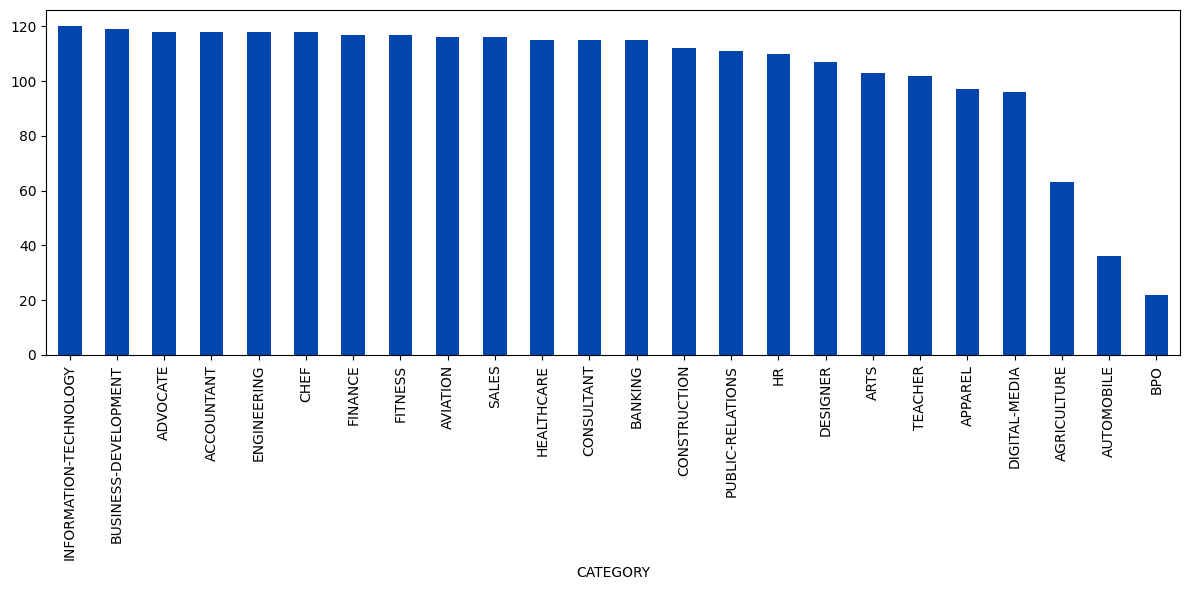

In [23]:
fig = df_resumes["CATEGORY"].value_counts().sort_values(ascending = False).plot(
    kind = "bar", 
    figsize = (12, 6),
    color = "#0245ac"
).get_figure()
fig.tight_layout()
fig.savefig("category_frequencies.jpg", dpi = 600)
plt.show()

In [24]:
df_resumes['RESUME_JSON']

ID
16852973    {'Summary': 'dedicated customer service manage...
22323967    {'Summary': 'versatile medium professional bac...
33176873    {'Summary': '20 year experience 15 plus year h...
27018550    {'Summary': 'dynamic 20 year customer service ...
17812897    {'Highlights': 'hr skill hr department startup...
                                  ...                        
12043694    {'Career Focus': 'obtain rewarding position pr...
99416532    {'Summary': 'motivated logistics successful ma...
24589765    {'Summary': 'strategically highly experienced ...
31605080    {'Professional Profile': 'support specialist e...
21190805    {'Summary': 'highly tech savvy professional 9 ...
Name: RESUME_JSON, Length: 2481, dtype: object

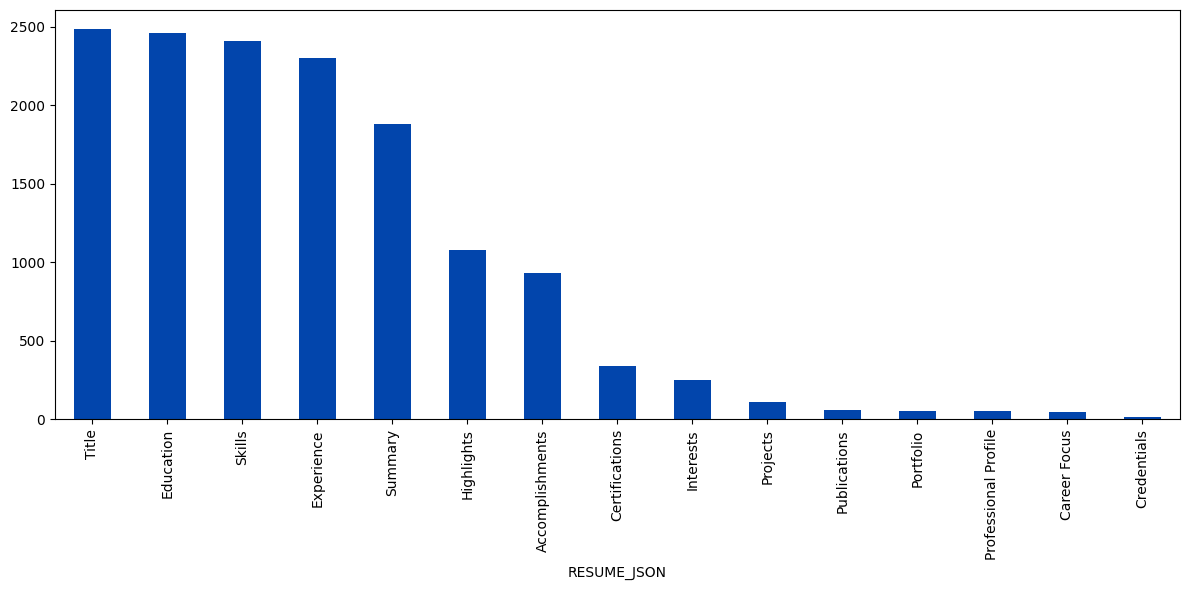

In [25]:
fig = df_resumes["RESUME_JSON"].apply(lambda resume_json: list(resume_json.keys())).explode().value_counts().plot(
    kind = "bar", 
    figsize = (12, 6),
    color = "#0245ac"
).get_figure()
fig.tight_layout()
fig.savefig("resume_sections.jpg", dpi = 600)
plt.show()

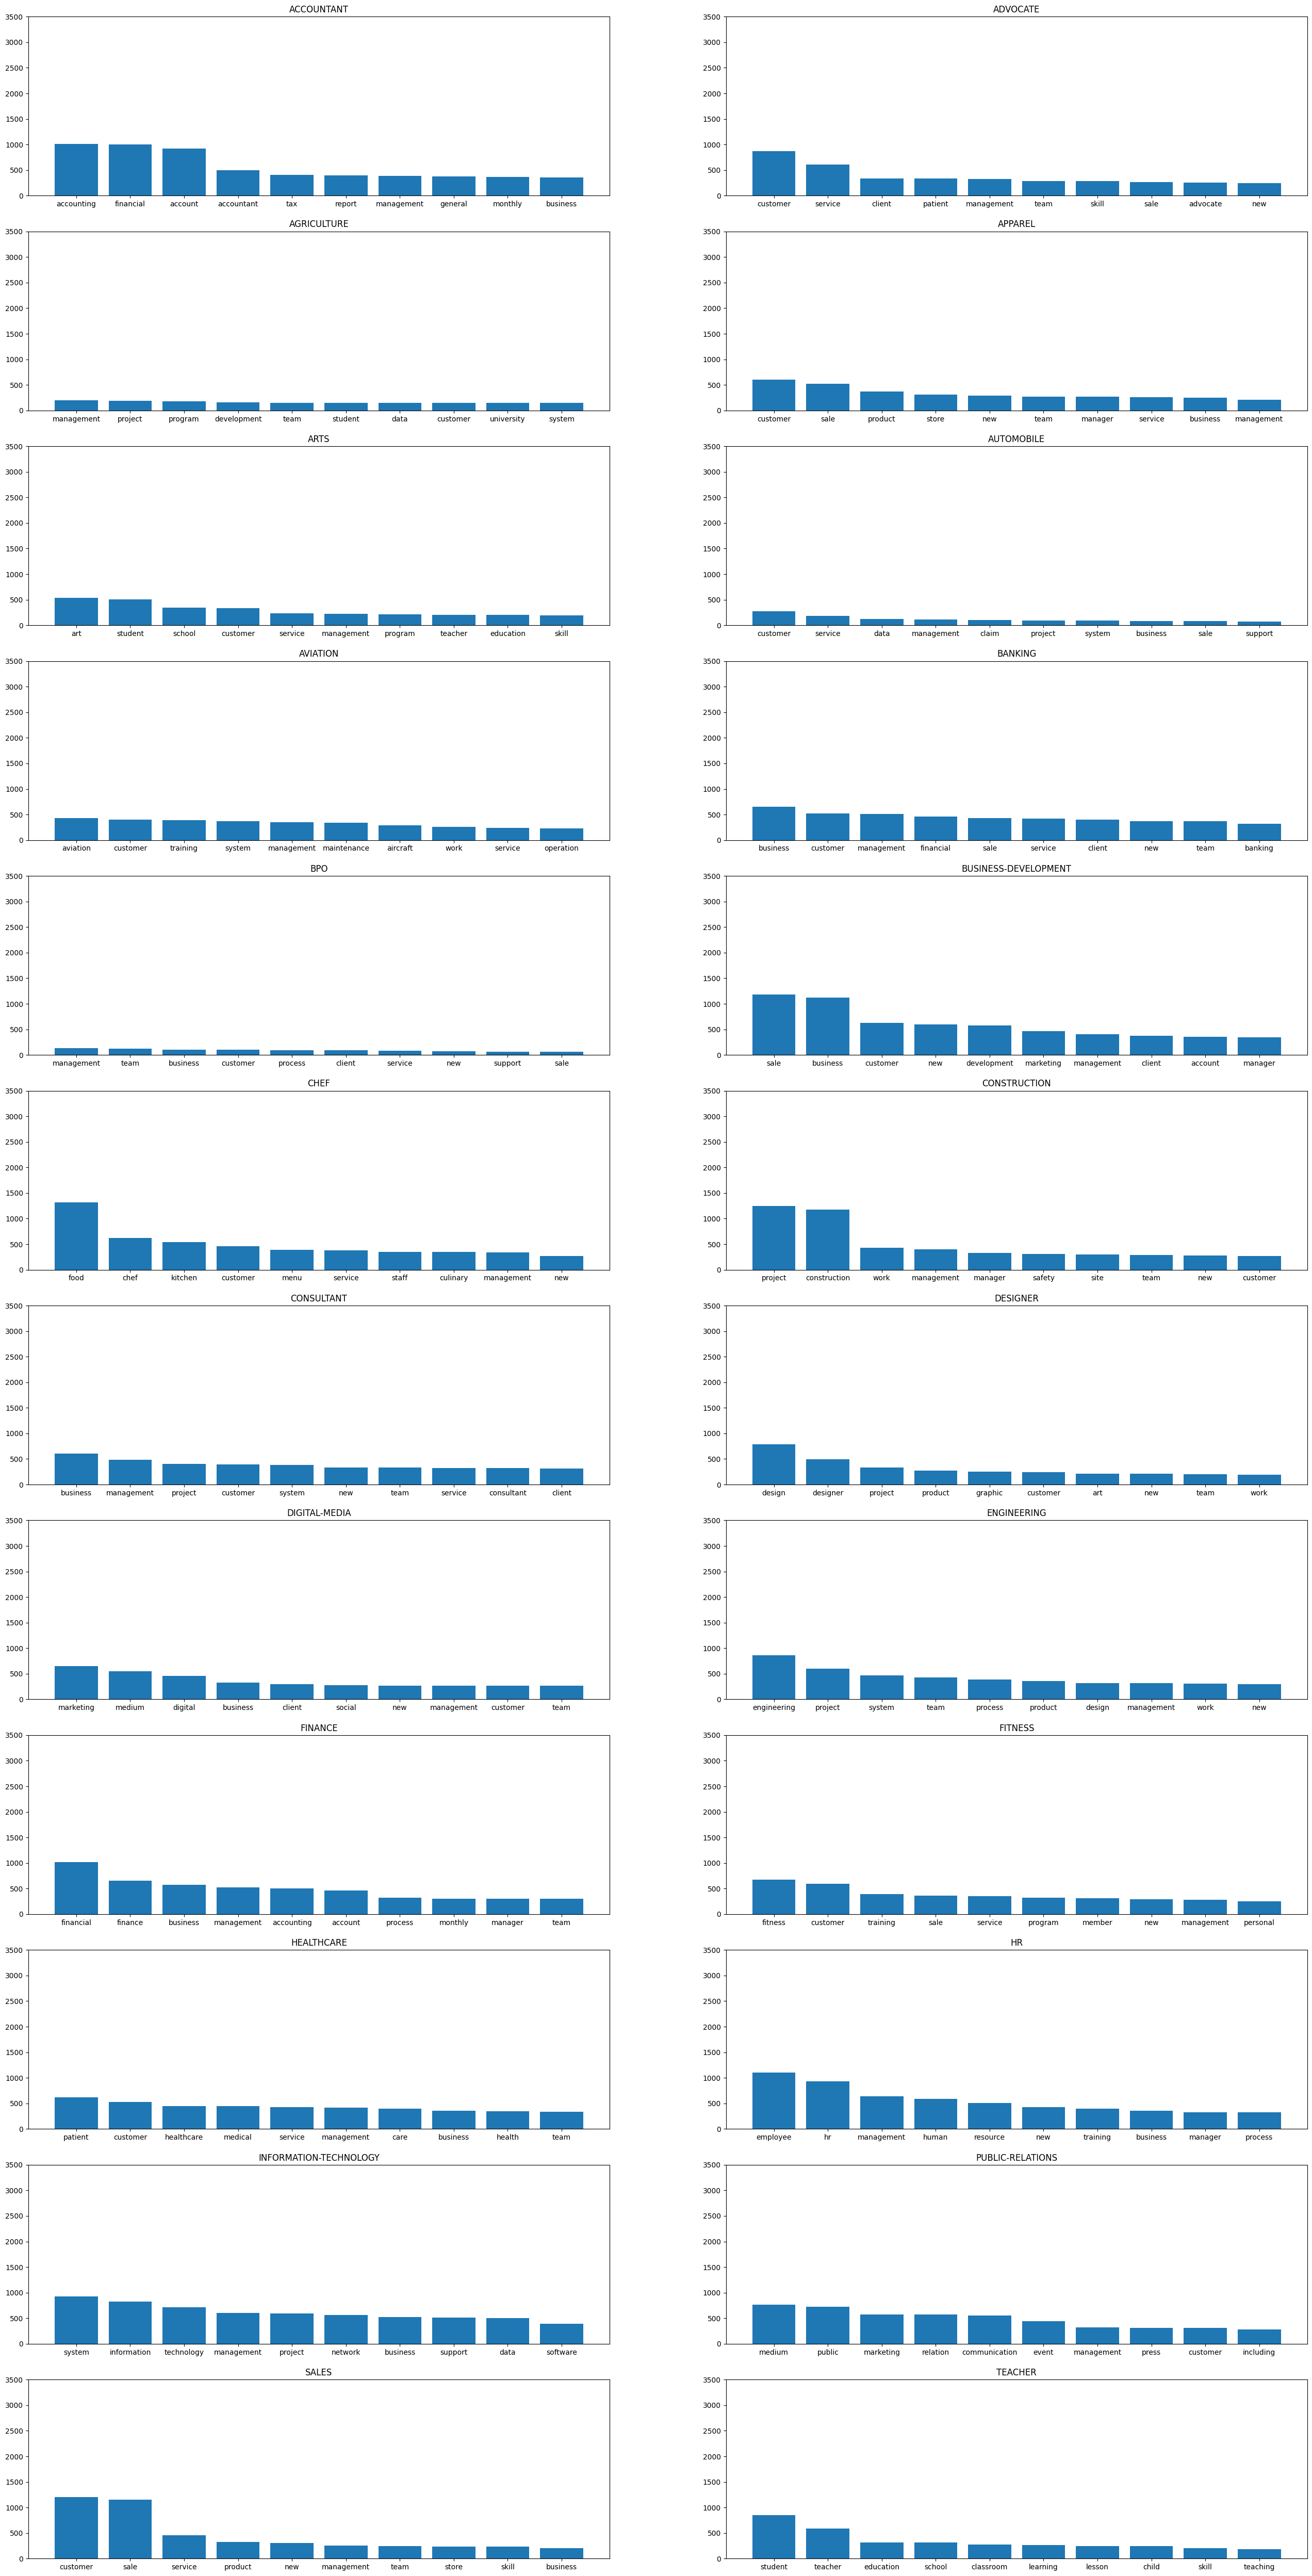

In [26]:
# word frequency for each category
def wordfreq(df):
    count = df['RESUME_STR_PREPROCESSED'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

fig = plt.figure(figsize=(32, 64))

all_wf_words = []
for i, cat in enumerate(np.sort(df_resumes['CATEGORY'].unique())):
    wf = wordfreq(df_resumes[df_resumes['CATEGORY']==cat])
    all_wf_words += list(wf['Word']) 
    fig.add_subplot(12, 2, i + 1).set_title(cat)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()

# Category prediction

In [27]:
categories = list(df_resumes['CATEGORY'].unique())
data_df = df_resumes[["RESUME_JSON", "RESUME_STR_PREPROCESSED", "CATEGORY_ENCODED"]]
data_df = data_df['RESUME_JSON'].apply(pd.Series).merge(data_df, left_index = True, right_index = True).drop(["RESUME_JSON"], axis = 1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2481 entries, 16852973 to 21190805
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Summary                  1881 non-null   object
 1   Highlights               1081 non-null   object
 2   Accomplishments          930 non-null    object
 3   Experience               2299 non-null   object
 4   Education                2457 non-null   object
 5   Skills                   2405 non-null   object
 6   Title                    2481 non-null   object
 7   Publications             62 non-null     object
 8   Interests                251 non-null    object
 9   Certifications           339 non-null    object
 10  Professional Profile     51 non-null     object
 11  Projects                 113 non-null    object
 12  Credentials              15 non-null     object
 13  Portfolio                52 non-null     object
 14  Career Focus             48 non-nu

In [28]:
X = data_df.drop('CATEGORY_ENCODED', axis=1)
y = data_df['CATEGORY_ENCODED']

X_train_index, X_test_index, y_train, y_test = train_test_split(X.index, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [29]:
def tfidf_vectorizer(train_data, test_data):
    tfidf = TfidfVectorizer()
    train_tfidf_data = tfidf.fit_transform(train_data)
    test_tfidf_data = tfidf.transform(test_data)
    return train_tfidf_data, test_tfidf_data

def count_vectorizer(train_data, test_data):
    count = CountVectorizer()
    train_count_data = count.fit_transform(train_data)
    test_count_data = count.transform(test_data)
    return train_count_data, test_count_data, count

def train_eval(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    return model.score(test_x, test_y)

## Whole dataset

In [30]:
X_train_whole_resume = X['RESUME_STR_PREPROCESSED'][X_train_index]
X_test_whole_resume = X['RESUME_STR_PREPROCESSED'][X_test_index]

### TF-IDF

In [47]:
X_train_tfidf, X_test_tfidf = tfidf_vectorizer(X_train_whole_resume, X_test_whole_resume)

logreg = LogisticRegression()
print(train_eval(logreg, X_train_tfidf, y_train, X_test_tfidf, y_test))

nb = MultinomialNB()
print(train_eval(nb, X_train_tfidf, y_train, X_test_tfidf, y_test))

xgb_classifier = xgb.XGBClassifier()
print(train_eval(xgb_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test))

0.6604026845637584
0.5355704697986577
0.7476510067114094


### Count Vectorizer

In [53]:
X_train_count, X_test_count, BOW = count_vectorizer(X_train_whole_resume, X_test_whole_resume)  

logreg = LogisticRegression()
print(train_eval(logreg, X_train_count, y_train, X_test_count, y_test))

nb = MultinomialNB()
print(train_eval(nb, X_train_count, y_train, X_test_count, y_test))

xgb_classifier = xgb.XGBClassifier()
print(train_eval(xgb_classifier, X_train_count, y_train, X_test_count, y_test))

0.6604026845637584
0.5114093959731544
0.7651006711409396


### Word2Vec

In [56]:
# Load spaCy model with word vectors
nlp = en_core_web_md.load()
print("Word vectorizer loaded")

print("Transforming training to word vectors...")
X_train_w2v = np.array([nlp(text).vector for text in X_train_whole_resume])
print("Transforming testing to word vectors...")
X_test_w2v = np.array([nlp(text).vector for text in X_test_whole_resume])
# Normalize the data to be non-negative
scaler = MinMaxScaler()

X_train_w2v_scaled = scaler.fit_transform(X_train_w2v)
X_test_w2v_scaled = scaler.transform(X_test_w2v)


Word vectorizer loaded
Transforming training to word vectors...
Transforming testing to word vectors...


In [57]:
logreg = LogisticRegression()
print(train_eval(logreg, X_train_w2v_scaled, y_train, X_test_w2v_scaled, y_test))

nb = MultinomialNB()
print(train_eval(nb, X_train_w2v_scaled, y_train, X_test_w2v_scaled, y_test))

xgb_classifier = xgb.XGBClassifier()
print(train_eval(xgb_classifier, X_train_w2v_scaled, y_train, X_test_w2v_scaled, y_test))

c:\Users\eduar\uni\UTS\NLP\assignment_2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5543624161073826
0.47248322147651006
0.48322147651006714


### BERT

In [ ]:
bert_encoder = transformers.BertModel.from_pretrained('bert-base-uncased')
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

def encode_text(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = input_ids[:512]
    input_ids = input_ids + [0] * (512 - len(input_ids))
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        output = bert_encoder(input_ids)
    return output[0][:, 0, :].numpy()

print("Transforming training to BERT vectors...")
X_train_bert = np.array([encode_text(text) for text in X_train_whole_resume])
print("Transforming testing to BERT vectors...")
X_test_bert = np.array([encode_text(text) for text in X_test_whole_resume])

scaler = MinMaxScaler()

X_train_bert_scaled = scaler.fit_transform(X_train_bert.reshape(-1, 768))
X_test_bert_scaled = scaler.transform(X_test_bert.reshape(-1, 768))

In [69]:
logreg = LogisticRegression()
print(train_eval(logreg, X_train_bert_scaled, y_train_bert, X_test_bert_scaled, y_test_bert))

nb = MultinomialNB()
print(train_eval(nb, X_train_bert_scaled, y_train_bert, X_test_bert_scaled, y_test_bert))

xgb_classifier = xgb.XGBClassifier()
print(train_eval(xgb_classifier, X_train_bert_scaled, y_train_bert, X_test_bert_scaled, y_test_bert))

c:\Users\eduar\uni\UTS\NLP\assignment_2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.44646464646464645
0.08484848484848485
0.3292929292929293


## By Section

In [71]:
X_train_by_section = X[RESUME_SECTIONS].loc[X_train_index].fillna("")
X_test_by_section = X[RESUME_SECTIONS].loc[X_test_index].fillna("")

### TF-IDF

In [99]:
X_train_sect_list = []
X_test_sect_list = []

for sect in RESUME_SECTIONS:
    X_train_sect_temp, X_test_sect_temp = tfidf_vectorizer(X_train_by_section[sect], X_test_by_section[sect])
    X_train_sect_list.append(X_train_sect_temp)
    X_test_sect_list.append(X_test_sect_temp)

X_train_tfidf_sect = sparse.hstack(X_train_sect_list).tocsr()
X_test_tfidf_sect = sparse.hstack(X_test_sect_list).tocsr()

xgb_model = xgb.XGBClassifier()
train_eval(xgb_model, X_train_tfidf_sect, y_train, X_test_tfidf_sect, y_test)

0.8348993288590604

### Count Vectorizer

In [101]:
X_train_sect_list = []
X_test_sect_list = []

for sect in RESUME_SECTIONS:
    X_train_sect_temp, X_test_sect_temp, count = count_vectorizer(X_train_by_section[sect], X_test_by_section[sect])
    X_train_sect_list.append(X_train_sect_temp)
    X_test_sect_list.append(X_test_sect_temp)

X_train_sect_count = sparse.hstack(X_train_sect_list).tocsr()
X_test_sect_count = sparse.hstack(X_test_sect_list).tocsr()

xgb_model = xgb.XGBClassifier()
train_eval(xgb_model, X_train_sect_count, y_train, X_test_sect_count, y_test)

0.8375838926174497

## Only Relevant Sections

### TF-IDF

In [105]:
X_train_sect_list = []
X_test_sect_list = []

for sect in RELEVANT_SECTIONS:
    X_train_sect_temp, X_test_sect_temp = tfidf_vectorizer(X_train_by_section[sect], X_test_by_section[sect])
    X_train_sect_list.append(X_train_sect_temp)
    X_test_sect_list.append(X_test_sect_temp)

X_train_tfidf_rel_sect = sparse.hstack(X_train_sect_list).tocsr()
X_test_tfidf_rel_sect = sparse.hstack(X_test_sect_list).tocsr()

xgb_model = xgb.XGBClassifier()
train_eval(xgb_model, X_train_tfidf_rel_sect, y_train, X_test_tfidf_rel_sect, y_test)

0.8308724832214766

### Count Vectorizer

In [72]:
X_train_sect_list = []
X_test_sect_list = []

for sect in RELEVANT_SECTIONS:
    X_train_sect_temp, X_test_sect_temp, count = count_vectorizer(X_train_by_section[sect], X_test_by_section[sect])
    X_train_sect_list.append(X_train_sect_temp)
    X_test_sect_list.append(X_test_sect_temp)

X_train_rel_sect_count = sparse.hstack(X_train_sect_list).tocsr()
X_test_rel_sect_count = sparse.hstack(X_test_sect_list).tocsr()

xgb_model = xgb.XGBClassifier()
train_eval(xgb_model, X_train_rel_sect_count, y_train, X_test_rel_sect_count, y_test)

0.8389261744966443

## Grid search on the best option

In [73]:
X_train_best = X_train_rel_sect_count
X_test_best = X_test_rel_sect_count

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1],
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, verbose=4)
grid_search.fit(X_train_best, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

test_accuracy = best_model.score(X_test_best, y_test)
print("Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Test Accuracy: 0.8450704225352113


In [99]:
import pickle
file_name = 'best_model.pkl'

pickle.dump(best_model, open(file_name, "wb"))

# Result Exploration

In [14]:
import pickle
file_name = 'best_model.pkl'

best_model = pickle.load(open(file_name, "rb"))
assert best_model.score(X_test_best, y_test) == 0.8450704225352113

## General Accuracy

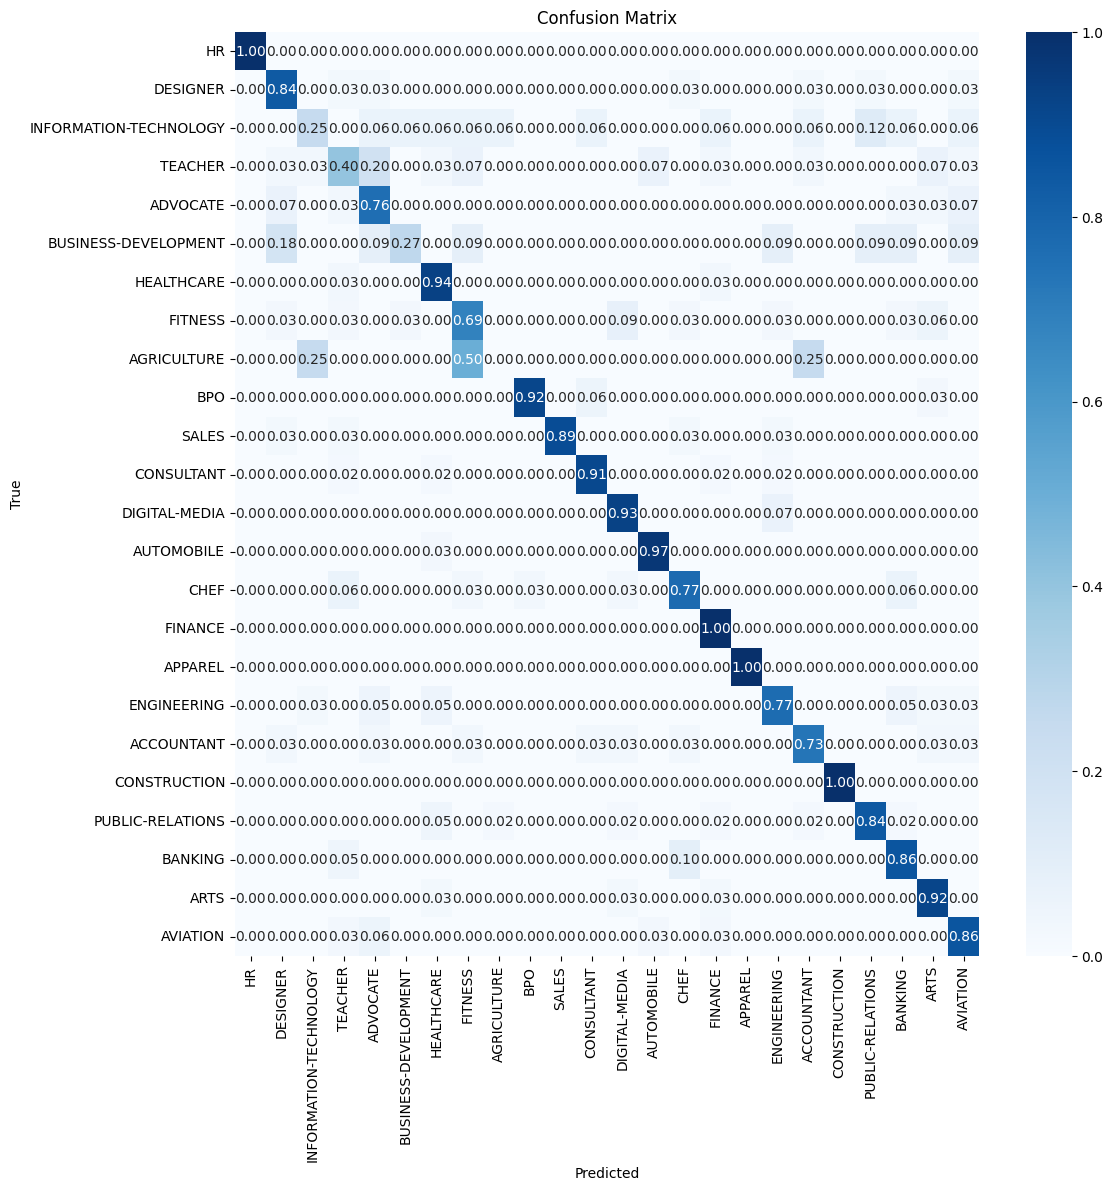

In [129]:
# plot the confusion matrix on the xgb_model on the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test_best)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.close()

In [19]:
# get the top-3 accuracy
def top3_accuracy(y_true, y_pred):
    count = 0
    for label, top3 in zip(y_true, y_pred):
        if label in top3:
            count += 1
    return count / len(y_true)

y_pred_proba = best_model.predict_proba(X_test_best)
y_pred_top3 = np.argsort(y_pred_proba, axis=1)[:, -3:]

y_test_np = np.array(y_test)

print(top3_accuracy(y_test_np, y_pred_top3))

0.937625754527163


## SHAP

In [20]:
bow_section = {}
feature2word = {}
prev_feature = 0
for sect in RELEVANT_SECTIONS:
    embedded_data, _, BOW = count_vectorizer(X_train_by_section[sect], X_test_by_section[sect])
    new_dict = {int(v)+prev_feature: k for k, v in BOW.vocabulary_.items()}
    feature2word.update(new_dict)
    prev_feature += embedded_data.shape[1]

This code always leads to a kernel error, so I will not run it here.

In [21]:
"""
import shap

# Choose the class of interest
class_index = cat2idx['ADVOCATE']  # Change this to the index of the class you're interested in

# Create a SHAP explainer object
X_train_best_array = X_train_best.toarray()
X_test_best_array = X_test_best.toarray()

explainer = shap.Explainer(best_model, X_train_best_array)

# Calculate SHAP values for all features
shap_values = explainer.shap_values(X_test_best_array)

# Calculate absolute SHAP values for the specified class
class_shap_values = np.abs(shap_values[class_index])

top_feature_indices = np.argsort(class_shap_values)[-10:]

# Get the corresponding words for the top features
top_words = [feature2word[i] for i in top_feature_indices]

# Print the top words and their corresponding SHAP values for the specified class
for word, shap_value in zip(top_words, class_shap_values[top_feature_indices]):
    print(f"Word: {word}, SHAP Value: {shap_value}")
    """


c:\Users\eduar\uni\UTS\NLP\assignment_2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

## NMF 

In [127]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

# Assume count_vectorizer and X_train, X_test, y_train, y_test are already defined
X_train_count, X_test_count, BOW = count_vectorizer(X_train_whole_resume, X_test_whole_resume)

# Supervised NMF
n_topics = len(y_test.unique())  # Number of topics
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X_train_count)  # Document-topic matrix
H = nmf.components_  # Topic-term matrix

# Encode the labels to ensure they are numeric
le = LabelEncoder()
y_train_encoded = y_train.copy()

# Determine the dominant topic for each document
document_topic = W.argmax(axis=1)

# Create a mapping from NMF topics to actual categories
topic_to_category = {}
for topic_idx in range(n_topics):
    # Get indices of documents assigned to the current topic
    topic_documents = (document_topic == topic_idx)
    # Find the most common category in these documents
    if topic_documents.any():
        most_common_category = mode(y_train_encoded[topic_documents])[0]
        topic_to_category[topic_idx] = label_encoder.inverse_transform([most_common_category])[0]
    else:
        topic_to_category[topic_idx] = 'Unknown'

# Display top words for each topic
feature_names = BOW.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    category = topic_to_category.get(topic_idx, 'Unknown')
    print(f"Topic {category}:")
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(" ".join(top_words))
    print()


Topic BUSINESS-DEVELOPMENT:
business development process analysis created finance goal strategic across new

Topic SALES:
customer service call cash maintained skill store product excellent high

Topic CONSTRUCTION:
project engineering development managed team manager system change cost engineer

Topic ACCOUNTANT:
financial accounting account monthly tax report general accountant finance statement

Topic CHEF:
food kitchen menu staff chef ensure dining item preparation quality

Topic TEACHER:
student school teacher education learning art classroom lesson university plan

Topic INFORMATION-TECHNOLOGY:
system network support information technology technical software server security window

Topic HR:
employee hr human resource new benefit policy job payroll management

Topic PUBLIC-RELATIONS:
medium public communication relation social event press managed including strategy

Topic ENGINEERING:
product new development team developed technical quality market technology production

Topic HEA

This is the closest we got to relating the H matrix indices to the original data.

## TF-IDF

In [111]:
comp_df = pd.DataFrame(columns=['category']+RELEVANT_SECTIONS, index=categories)
for category in categories:
    cat_df = X_train_by_section.loc[y_train[y_train==label_encoder.transform([category])[0]].index]
    cat_df.fillna('', inplace=True)
    new_row = {key: "" for key in comp_df.columns}  # Create a dictionary for the new row
    new_row['category'] = category
    for sect in RELEVANT_SECTIONS:
        new_row[sect] = " ".join(cat_df[sect].values)
    comp_df.loc[category] = new_row  # Add the new row to comp_df using .loc[]
comp_df.set_index('category', inplace=True)
comp_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, HR to AVIATION
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            24 non-null     object
 1   Summary          24 non-null     object
 2   Experience       24 non-null     object
 3   Education        24 non-null     object
 4   Skills           24 non-null     object
 5   Projects         24 non-null     object
 6   Highlights       24 non-null     object
 7   Accomplishments  24 non-null     object
dtypes: object(8)
memory usage: 1.7+ KB


In [113]:
top_words = {}
for section in RELEVANT_SECTIONS:
    tfidf_words = TfidfVectorizer(preprocessor=preprocess_section)
    section_text = comp_df[section].values
    tfidf_matrix = tfidf_words.fit_transform(section_text)
    feature_names = tfidf_words.get_feature_names_out()
    for category in categories:
        category_idx = comp_df.index.get_loc(category)
        category_tfidf_scores = tfidf_matrix[category_idx]
        top_word_indices = np.argsort(category_tfidf_scores.toarray()[0])[::-1][:3]
        top_words_list = [(feature_names[idx], category_tfidf_scores[0, idx]) for idx in top_word_indices]
        if category not in top_words:
            top_words[category] = {}
        top_words[category][section] = top_words_list

# Print the top 3 words for each category in each section
category = 'CONSTRUCTION'
for section in top_words[category]:
    print(f"  Section: {section}")
    for word, tfidf_score in top_words[category][section]:
        print(f"    Word: {word}, TF-IDF: {tfidf_score:.4f}")

  Section: Title
    Word: construction, TF-IDF: 0.9101
    Word: manager, TF-IDF: 0.1869
    Word: project, TF-IDF: 0.1237
  Section: Summary
    Word: construction, TF-IDF: 0.6249
    Word: project, TF-IDF: 0.3089
    Word: manager, TF-IDF: 0.1493
  Section: Experience
    Word: project, TF-IDF: 0.5041
    Word: construction, TF-IDF: 0.4928
    Word: work, TF-IDF: 0.1366
  Section: Education
    Word: construction, TF-IDF: 0.4146
    Word: engineering, TF-IDF: 0.2158
    Word: university, TF-IDF: 0.1880
  Section: Skills
    Word: construction, TF-IDF: 0.4491
    Word: project, TF-IDF: 0.3320
    Word: management, TF-IDF: 0.1595
  Section: Projects
    Word: construction, TF-IDF: 0.3910
    Word: project, TF-IDF: 0.3142
    Word: ca, TF-IDF: 0.1837
  Section: Highlights
    Word: construction, TF-IDF: 0.3269
    Word: management, TF-IDF: 0.2557
    Word: project, TF-IDF: 0.1991
  Section: Accomplishments
    Word: construction, TF-IDF: 0.5932
    Word: project, TF-IDF: 0.3735
    Wor